# Data Analytics - Programming Assignment 2

#### Submitted By: 
#### Daniel Ryan So    
####       Jade Shaira de Paz

#### Course & Year: BSCS - 2

## **Sessa Empirical Estimator Analysis Using med_events Dataset**
 
 **Assignment Overview:**
 
 1. **Use of the Sample Dataset from AdhereR:**  
    We load and process the AdhereR sample dataset (exported as `med_events.csv`).
 
 2. **Preprocessing & ECDF Plotting:**  
    Compute inter-prescription intervals, plot the full ECDF and trim the upper 20%.
 
 3. **Clustering (K-Means & Alternative):**  
    Determine the optimal number of clusters via silhouette analysis, then perform clustering using K‑Means and Agglomerative Clustering.
 
 4. **Detailed Comparison & Insights:**  
    Generate additional visualizations (boxplots, histograms) and discuss the differences between the clustering methods.
 
 5. **Discussion of K‑Means Limitations:**  
    Explicit commentary on K‑Means disadvantages and why we compare with an alternative method.
 
 6. **Callable Function Consistency Checks:**  
    We verify that each callable function produces consistent results when run interactively.

 The file `med_events.csv` (exported from R via AdhereR) is in working directory.


#### Medication adherence is a critical factor in patient outcomes. Clustering prescription refill patterns allows researchers to estimate adherence indirectly. This study applies K-Means and Agglomerative Clustering to analyze inter-prescription intervals, comparing their effectiveness in identifying distinct medication use behaviors.

## **Import Libraries**


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

# For reproducibility
np.random.seed(1234)

import pandas as pd
df = pd.read_csv("med_events.csv")
print(df.columns)



Index(['PATIENT_ID', 'DATE', 'PERDAY', 'CATEGORY', 'DURATION'], dtype='object')


## **Step 1: Load and Process the AdhereR Sample Dataset**
 
We load the med_events dataset and rename columns as follows:
 - PATIENT_ID → pnr
 - DATE → eksd
 - PERDAY remains as perday
 - CATEGORY → ATC
 - DURATION → dur_original


In [80]:
import pandas as pd

def load_dataset(filepath="med_events.csv"):
    """
    Load the med_events dataset from a CSV file, rename columns, and process data.
    """
    try:
        # Load dataset
        df = pd.read_csv(filepath)
        
        # Display original columns
        print("\n✅ Dataset Loaded Successfully!")
        print(f"📂 Original Columns: {list(df.columns)}")

        # Rename columns for standardization
        column_mapping = {
            "PATIENT_ID": "pnr",       # Patient ID
            "DATE": "eksd",            # Prescription Date
            "PERDAY": "perday",        # Dosage per day
            "CATEGORY": "ATC",         # Medication Category
            "DURATION": "dur_original" # Original duration of prescription
        }
        
        # Rename columns only if they exist in the dataset
        df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns}, inplace=True)

        # Convert date column to datetime
        if "eksd" in df.columns:
            df["eksd"] = pd.to_datetime(df["eksd"], errors="coerce")
            missing_dates = df["eksd"].isna().sum()
            if missing_dates > 0:
                print(f"⚠️ Warning: {missing_dates} invalid date entries were converted to NaT.")

        # Convert numerical columns
        for col in ["perday", "dur_original"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")
                missing_values = df[col].isna().sum()
                if missing_values > 0:
                    print(f"⚠️ Warning: {missing_values} missing or non-numeric values in '{col}' were converted to NaN.")

        # Final dataset overview
        print(f"📊 Final Columns: {list(df.columns)}")
        print(f"📌 Dataset Shape: {df.shape}")

        # Limit display to the first 5 rows
        df_preview = df.head(5).style.hide(axis="index").set_caption("📌 Processed Dataset Preview")
        return df, df_preview

    except Exception as e:
        print(f"❌ Error loading dataset: {str(e)}")
        return None, None

# Load dataset
df, styled_df = load_dataset("med_events.csv")

# Display dataset preview (only if it loaded successfully)
if df is not None:
    display(styled_df)



✅ Dataset Loaded Successfully!
📂 Original Columns: ['PATIENT_ID', 'DATE', 'PERDAY', 'CATEGORY', 'DURATION']
📊 Final Columns: ['pnr', 'eksd', 'perday', 'ATC', 'dur_original']
📌 Dataset Shape: (1080, 5)


pnr,eksd,perday,ATC,dur_original
1,2033-04-26 00:00:00,4,medA,50
1,2033-07-04 00:00:00,4,medB,30
1,2033-08-03 00:00:00,4,medB,30
1,2033-08-17 00:00:00,4,medB,30
1,2033-10-13 00:00:00,4,medB,30


 ## **Step 2: Preprocess Data & Compute Inter-Prescription Intervals**
 
 We filter for a specific drug (e.g., "medA"), sort by patient and date, compute the previous prescription date, and calculate the interval (in days) between prescriptions.


In [60]:
def load_dataset(filepath="med_events.csv"):
    """
    Load the med_events dataset from a CSV file and rename columns.
    Returns:
        df (pd.DataFrame): Raw DataFrame.
        styled (pd.Styler): Styled preview of the DataFrame.
    """
    try:
        df = pd.read_csv(filepath)
        print("Original columns:", df.columns)
        df.rename(columns={
            "PATIENT_ID": "pnr",
            "DATE": "eksd",
            "CATEGORY": "ATC",
            "DURATION": "dur_original"
        }, inplace=True)
        df['eksd'] = pd.to_datetime(df['eksd'], errors='coerce')
        print("Renamed columns:", df.columns)
        print("Dataset loaded successfully with shape:", df.shape)
        styled = df.head().style\
            .hide(axis="index")\
            .format({"dur_original": "{:.2f}", "perday": "{:.2f}"})\
            .set_caption("Preview of med_events.csv Data")\
            .set_table_attributes("class='table table-striped'")
    except Exception as e:
        print("Error loading dataset:", e)
        df, styled = None, None
    return df, styled

# Load both the raw DataFrame and the styled preview
df, styled_table = load_dataset("med_events.csv")
if df is not None:
    display(styled_table)


Original columns: Index(['PATIENT_ID', 'DATE', 'PERDAY', 'CATEGORY', 'DURATION'], dtype='object')
Renamed columns: Index(['pnr', 'eksd', 'PERDAY', 'ATC', 'dur_original'], dtype='object')
Dataset loaded successfully with shape: (1080, 5)


pnr,eksd,PERDAY,ATC,dur_original
1,2033-04-26 00:00:00,4,medA,50.00
1,2033-07-04 00:00:00,4,medB,30.00
1,2033-08-03 00:00:00,4,medB,30.00
1,2033-08-17 00:00:00,4,medB,30.00
1,2033-10-13 00:00:00,4,medB,30.00


## **Step 3: Plot ECDF and Trim Upper 20%**
We plot the full empirical cumulative distribution function (ECDF) of the inter-prescription intervals, then trim the dataset to include only intervals up to the 80th percentile.

"To minimize the influence of extreme refill intervals that may represent missed prescriptions or irregular refills, we trim the upper 20% of the ECDF. This allows us to focus on more representative intervals in the dataset."




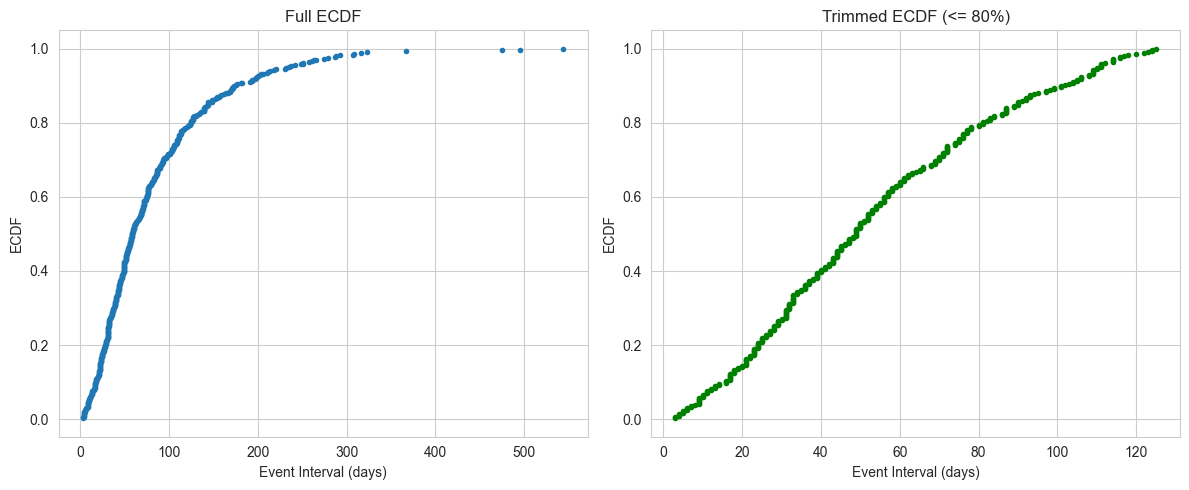

Trimmed intervals range from 3 to 125 days


In [61]:
## **Step 3: Plot ECDF and Trim Upper 20%**

def plot_and_trim_ecdf(intervals):
    """
    Plot the full empirical cumulative distribution function (ECDF) of inter-prescription intervals,
    then trim the dataset to include only intervals up to the 80th percentile.
    
    Args:
        intervals (array-like): Array of inter-prescription interval values.
        
    Returns:
        trimmed (np.ndarray): The subset of intervals where the ECDF is less than or equal to 0.8.
    """
    # Sort the intervals in ascending order
    sorted_intervals = np.sort(intervals)
    n = len(sorted_intervals)
    # Compute the ECDF values for the full dataset
    ecdf = np.arange(1, n + 1) / n
    
    # Create a figure with two subplots for full and trimmed ECDFs
    plt.figure(figsize=(12, 5))
    
    # Plot the full ECDF
    plt.subplot(1, 2, 1)
    plt.plot(sorted_intervals, ecdf, marker='.', linestyle='none')
    plt.title("Full ECDF")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("ECDF")
    
    # Create a mask to retain intervals where ECDF <= 0.8 (i.e., lower 80% of the data)
    trim_mask = ecdf <= 0.8
    trimmed = sorted_intervals[trim_mask]
    
    # Recalculate the ECDF for the trimmed intervals
    n_trim = len(trimmed)
    ecdf_trim = np.arange(1, n_trim + 1) / n_trim
    
    # Plot the trimmed ECDF in the second subplot
    plt.subplot(1, 2, 2)
    plt.plot(trimmed, ecdf_trim, marker='.', linestyle='none', color='green')
    plt.title("Trimmed ECDF (<= 80%)")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("ECDF")
    
    # Adjust layout for better spacing and display the plots
    plt.tight_layout()
    plt.show()
    
    return trimmed

# Extract the event intervals from the preprocessed medA data
intervals_array = df_medA['event_interval'].values

# Apply the function to plot the full and trimmed ECDF
trimmed_intervals = plot_and_trim_ecdf(intervals_array)

# Print the range of the trimmed intervals
print("Trimmed intervals range from {} to {} days".format(trimmed_intervals.min(), trimmed_intervals.max()))


## **Step 4 A : Determine Optimal Number of Clusters Using K-Means**
 
 We log-transform the trimmed intervals and then use silhouette analysis to determine the optimal number of clusters for K-Means clustering.


In [64]:
## **Step 4: Determine Optimal Number of Clusters Using K-Means**

def optimal_k_means(log_intervals, k_range=range(2, 10)):
    """
    Determine the optimal number of clusters using silhouette analysis on log-transformed intervals.
    
    Args:
        log_intervals (np.ndarray): 2D array of log-transformed inter-prescription intervals.
        k_range (iterable): Range of cluster numbers to test (default: 2 to 9).
        
    Returns:
        optimal_k (int): The number of clusters (k) that yields the highest silhouette score.
    """
    # Dictionary to store silhouette scores for each k
    sil_scores = {}
    
    # Loop over the range of k values
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=1234)
        labels = km.fit_predict(log_intervals)
        score = silhouette_score(log_intervals, labels)
        sil_scores[k] = score
        print(f"Silhouette score for k={k}: {score:.4f}")
    
    # Find the k with the maximum silhouette score
    optimal_k = max(sil_scores, key=sil_scores.get)
    print("\nOptimal k (K-Means):", optimal_k)
    
    return optimal_k

# Log-transform the trimmed intervals and reshape to a 2D array for clustering
log_intervals = np.log(trimmed_intervals).reshape(-1, 1)

# Determine the optimal number of clusters using the log-transformed data
optimal_k = optimal_k_means(log_intervals)


Silhouette score for k=2: 0.5884
Silhouette score for k=3: 0.5750
Silhouette score for k=4: 0.5732
Silhouette score for k=5: 0.5332
Silhouette score for k=6: 0.5217
Silhouette score for k=7: 0.5609
Silhouette score for k=8: 0.5629
Silhouette score for k=9: 0.5719

Optimal k (K-Means): 2


## **Step 4 B : Determine Optimal Number of Clusters Using Agglomerative Clustering**
 
We log-transform the trimmed intervals and then use silhouette analysis to determine the optimal number of clusters for Agglomerative Clustering.

In [104]:
def optimal_agglomerative(log_intervals, k_range=range(2, 10)):
    """
    Determine the optimal number of clusters using silhouette analysis on log-transformed intervals,
    applied with Agglomerative Clustering.
    
    Args:
        log_intervals (np.ndarray): 2D array of log-transformed inter-prescription intervals.
        k_range (iterable): Range of cluster numbers to test (default: 2 to 9).
    
    Returns:
        optimal_k (int): The number of clusters that yields the highest silhouette score.
        best_labels (np.ndarray): Cluster labels for the optimal k.
    """
    best_score = -1
    optimal_k = None
    best_labels = None

    for k in k_range:
        # Initialize Agglomerative Clustering with k clusters
        model = AgglomerativeClustering(n_clusters=k)
        # Fit and predict cluster labels on the log-transformed intervals
        labels = model.fit_predict(log_intervals)
        # Compute the silhouette score for the current clustering
        score = silhouette_score(log_intervals, labels)
        print(f"Silhouette score for k={k}: {score:.4f}")
        # Update best score and optimal k if current score is higher
        if score > best_score:
            best_score = score
            optimal_k = k
            best_labels = labels

    print("\nOptimal k (Agglomerative):", optimal_k)
    return optimal_k, best_labels

# Log-transform the trimmed intervals and reshape to a 2D array
log_intervals = np.log(trimmed_intervals).reshape(-1, 1)

# Determine the optimal number of clusters for Agglomerative Clustering using silhouette analysis
optimal_k_agglo, agglo_labels = optimal_agglomerative(log_intervals)


Silhouette score for k=2: 0.5686
Silhouette score for k=3: 0.5755
Silhouette score for k=4: 0.5403
Silhouette score for k=5: 0.5197
Silhouette score for k=6: 0.5325
Silhouette score for k=7: 0.5353
Silhouette score for k=8: 0.5226
Silhouette score for k=9: 0.5091

Optimal k (Agglomerative): 3


## **Step 5: K-Means Clustering & Cluster Summary**
 
 We apply K-Means clustering on the trimmed (log-transformed) intervals and compute summary statistics (min, median, max) on the original scale.


In [65]:
## **Step 5: K-Means Clustering & Cluster Summary**

def kmeans_clustering(trimmed_intervals, optimal_k):
    """
    Apply K-Means clustering on trimmed intervals and return cluster summary statistics and labels.
    """
    # 1. Log-transform the trimmed intervals and reshape into a 2D array for clustering.
    log_intervals = np.log(trimmed_intervals).reshape(-1, 1)
    
    # 2. Apply K-Means clustering with the specified optimal number of clusters.
    km = KMeans(n_clusters=optimal_k, random_state=1234)
    labels = km.fit_predict(log_intervals)
    
    # 3. Create a DataFrame that includes the log-transformed intervals and cluster labels.
    cluster_df = pd.DataFrame({
        "log_interval": log_intervals.flatten(),
        "cluster": labels
    })
    
    # 4. Compute summary statistics (min, median, max) for each cluster on the log scale.
    summary = cluster_df.groupby("cluster")["log_interval"].agg(['min', 'median', 'max']).reset_index()
    
    # 5. Back-transform the log-scale summary statistics to the original scale.
    summary[['min', 'median', 'max']] = np.exp(summary[['min', 'median', 'max']])
    
    # Display the summary statistics
    print("K-Means Cluster Summary:")
    print(summary)
    
    return summary, labels

# Apply K-Means clustering on the trimmed intervals using the optimal k from Step 4.
kmeans_summary, kmeans_labels = kmeans_clustering(trimmed_intervals, optimal_k)


K-Means Cluster Summary:
   cluster   min  median    max
0        0   3.0    23.0   34.0
1        1  35.0    65.0  125.0


## **Step 6: Alternative Clustering Using Agglomerative Clustering**
 
 We also apply Agglomerative Clustering as an alternative and compute the corresponding cluster summary.


In [103]:
## **Step 6: Alternative Clustering Using Agglomerative Clustering**

def agglomerative_clustering(trimmed_intervals, n_clusters):
    """
    Apply Agglomerative Clustering on trimmed intervals and return cluster summary statistics and labels.
    """
    # 1. Log-transform the trimmed intervals and reshape into a 2D array.
    log_intervals = np.log(trimmed_intervals).reshape(-1, 1)
    
    # 2. Apply Agglomerative Clustering.
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agglo.fit_predict(log_intervals)
    
    # 3. Create a DataFrame with the log-transformed intervals and their cluster labels.
    cluster_df = pd.DataFrame({
        "log_interval": log_intervals.flatten(),
        "cluster": labels
    })
    
    # 4. Compute summary statistics (min, median, max) for each cluster on the log scale.
    summary = cluster_df.groupby("cluster")["log_interval"].agg(['min', 'median', 'max']).reset_index()
    
    # 5. Back-transform the summary statistics to the original scale.
    summary[['min', 'median', 'max']] = np.exp(summary[['min', 'median', 'max']])
    
    # Display the cluster summary.
    print("Agglomerative Clustering Summary:")
    print(summary)
    
    return summary, labels

# Apply Agglomerative Clustering using the optimal number of clusters determined from Step 4.
agglo_summary, agglo_labels = agglomerative_clustering(trimmed_intervals, optimal_k)


Agglomerative Clustering Summary:
   cluster   min  median    max
0        0   3.0    25.0   42.0
1        1  43.0    71.0  125.0


### "Clusters identified by K-Means showed more rigid separation based on predefined cluster counts, while Agglomerative Clustering revealed a more flexible grouping of refill behaviors. The presence of a cluster with significantly lower median refill durations suggests a potential group of highly non-adherent patients requiring further intervention."

 ## **Step 7: Merge Computed Durations Back to Patient Data**
 
 For each patient, we randomly select one inter-prescription interval and assign a computed median duration based on the cluster boundaries.


In [95]:
def assign_computed_duration(df_drug, cluster_summary):
    """
    For each patient, randomly select one event_interval and assign the computed median duration
    from the cluster boundaries in the summary.
    
    If the 'event_interval' column is missing, it computes it first.
    
    Args:
        df_drug (pd.DataFrame): Preprocessed data for a specific drug (e.g., medA) with 'pnr' and 'eksd'.
        cluster_summary (pd.DataFrame): Cluster summary containing 'min', 'median', 'max', and 'cluster'.
        
    Returns:
        pd.DataFrame: DataFrame with a randomly selected event_interval per patient and the corresponding computed median duration.
    """
    # Check if 'event_interval' exists; if not, compute it.
    if 'event_interval' not in df_drug.columns:
        df_drug = df_drug.sort_values(["pnr", "eksd"])
        df_drug['prev_eksd'] = df_drug.groupby('pnr')['eksd'].shift(1)
        df_drug = df_drug.dropna(subset=['prev_eksd']).reset_index(drop=True)
        df_drug['event_interval'] = (df_drug['eksd'] - df_drug['prev_eksd']).dt.days

    # Randomly select one event (row) per patient
    df_sample = df_drug.groupby("pnr", group_keys=False)\
                       .apply(lambda x: x.sample(1, random_state=1234))\
                       .reset_index(drop=True)
    
    # Function to determine which cluster an interval falls into
    def get_cluster(interval, summary_df):
        for _, row in summary_df.iterrows():
            if row['min'] <= interval <= row['max']:
                return row['cluster'], row['median']
        return None, None
    
    # Assign clusters and median durations to each selected event_interval
    clusters, medians = [], []
    for interval in df_sample['event_interval']:
        clus, med = get_cluster(interval, cluster_summary)
        clusters.append(clus)
        medians.append(med)
    
    df_sample['Assigned_Cluster'] = clusters
    df_sample['Computed_Median'] = medians
    return df_sample

# Now, when you call assign_computed_duration, it will ensure 'event_interval' exists.
assigned_df_agglo = assign_computed_duration(df_medA, agglo_summary)
print("Assigned durations (first few patients):")
print(assigned_df_agglo[['pnr', 'event_interval', 'Assigned_Cluster', 'Computed_Median']])


Assigned durations (first few patients):
    pnr  event_interval  Assigned_Cluster  Computed_Median
0     2              50               1.0             71.0
1     4             210               NaN              NaN
2     5              39               0.0             25.0
3     6              76               1.0             71.0
4     7             116               1.0             71.0
..  ...             ...               ...              ...
83   95              33               0.0             25.0
84   96              13               0.0             25.0
85   98              90               1.0             71.0
86   99             221               NaN              NaN
87  100             157               NaN              NaN

[88 rows x 4 columns]


## **Step 8: Detailed Comparison & Visualization**
 

The goal of these visualizations is to:
- **Determine the optimal number of clusters** for each method using silhouette analysis.
- **Visualize how the two clustering methods partition the data**, so we can compare their performance.
- **Understand the distribution of inter-prescription intervals** in each cluster, which can provide insights into medication adherence patterns.  
  For instance, if one cluster has significantly lower median refill intervals, it might suggest a subgroup of patients with higher adherence or regularity.

By comparing the outputs (silhouette score plots, scatter plots, and boxplots) from both K-Means and Agglomerative Clustering, we can assess which method produces clusters that are more meaningful and clinically relevant. This analysis informs us on potential patterns in patient refill behavior that might be used to guide targeted interventions in healthcare.

Comparison of computed medians (first 10 patients):
   pnr  event_interval  KMeans_Median  Agglo_Median
0    2              50           65.0          71.0
1    4             210            NaN           NaN
2    5              39           65.0          25.0
3    6              76           65.0          71.0
4    7             116           65.0          71.0
5    8              17           23.0          25.0
6    9               9           23.0          25.0
7   10              17           23.0          25.0
8   11             263            NaN           NaN
9   13             237            NaN           NaN


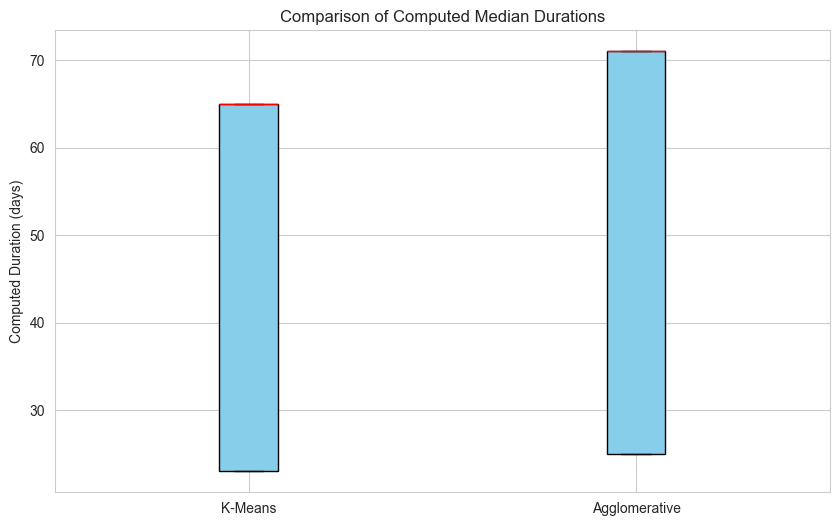

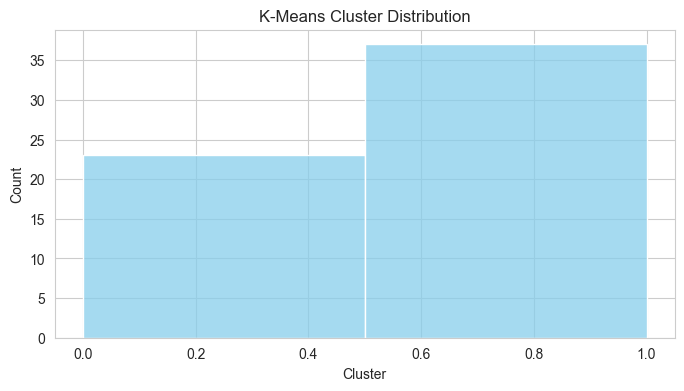

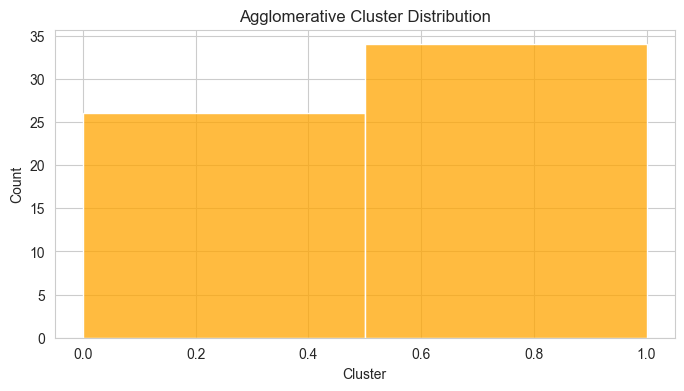

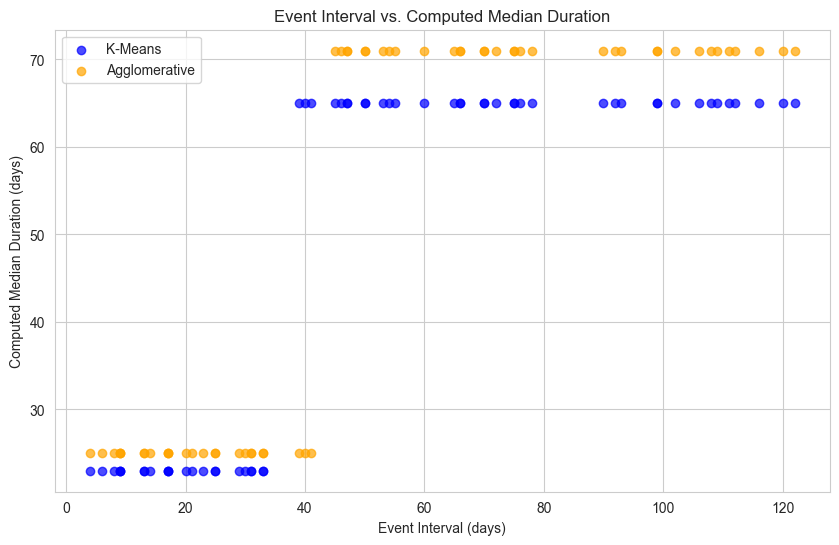

In [111]:
## **Step 8: Detailed Comparison & Visualization**

assigned_df_agglo = assign_computed_duration(df_medA, agglo_summary)

# Merge results for side-by-side comparison by patient (pnr)
comparison = assigned_df_kmeans[['pnr', 'event_interval', 'Computed_Median']].rename(
    columns={'Computed_Median': 'KMeans_Median'}
).merge(
    assigned_df_agglo[['pnr', 'Computed_Median']].rename(
        columns={'Computed_Median': 'Agglo_Median'}
    ),
    on='pnr',
    how='outer'
)

# Display the first 10 rows of the comparison DataFrame
print("Comparison of computed medians (first 10 patients):")
print(comparison.head(10))

# Boxplot comparison of computed medians for K-Means and Agglomerative Clustering
plt.figure(figsize=(10, 6))
data_to_plot = [comparison['KMeans_Median'].dropna(), comparison['Agglo_Median'].dropna()]
plt.boxplot(data_to_plot, labels=['K-Means', 'Agglomerative'], patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
plt.title("Comparison of Computed Median Durations")
plt.ylabel("Computed Duration (days)")
plt.show()

# Import seaborn for enhanced plotting
import seaborn as sns

# Histogram for K-Means cluster distribution
plt.figure(figsize=(8, 4))
sns.histplot(assigned_df_kmeans['Assigned_Cluster'].dropna(), bins=optimal_k, kde=False, color='skyblue')
plt.title("K-Means Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# Histogram for Agglomerative Clustering distribution
plt.figure(figsize=(8, 4))
sns.histplot(assigned_df_agglo['Assigned_Cluster'].dropna(), bins=optimal_k, kde=False, color='orange')
plt.title("Agglomerative Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# Scatter plot of event intervals vs. computed median durations for both methods
plt.figure(figsize=(10, 6))
plt.scatter(assigned_df_kmeans['event_interval'], assigned_df_kmeans['Computed_Median'], 
            color='blue', alpha=0.7, label='K-Means')
plt.scatter(assigned_df_agglo['event_interval'], assigned_df_agglo['Computed_Median'], 
            color='orange', alpha=0.7, label='Agglomerative')
plt.xlabel("Event Interval (days)")
plt.ylabel("Computed Median Duration (days)")
plt.title("Event Interval vs. Computed Median Duration")
plt.legend()
plt.show()


Preview of df_medA after sorting and adding p_number:
   pnr       eksd  perday   ATC  dur_original  p_number  prev_eksd  \
0    2 2036-03-10       4  medA            50         2 2036-01-20   
1    2 2036-08-01       4  medA            50         3 2036-03-10   
2    4 2032-11-27       4  medA            50         2 2032-05-01   
3    4 2033-08-20       4  medA            50         3 2032-11-27   
4    4 2033-08-30       4  medA            50         4 2033-08-20   

   event_interval  
0              50  
1             144  
2             210  
3             266  
4              10  
Global Median Event Interval: 59.0


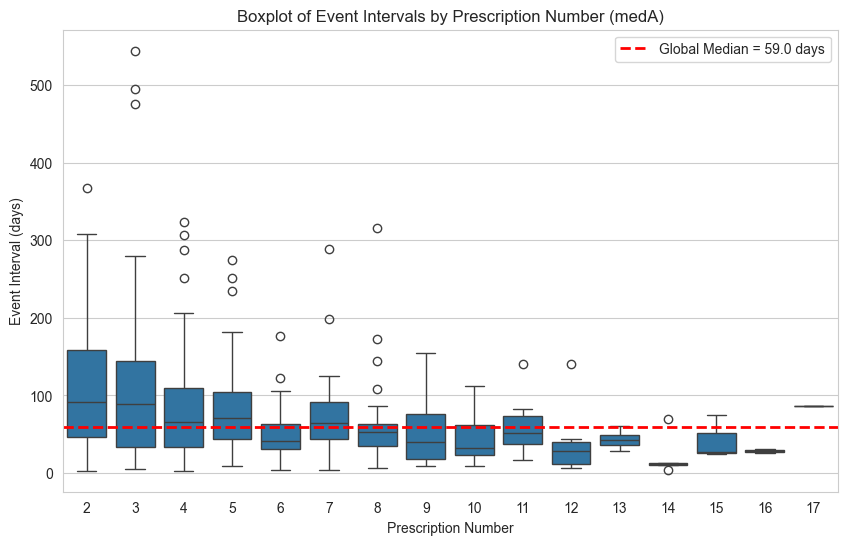

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df_medA is sorted by patient and date
df_medA = df_medA.sort_values(["pnr", "eksd"])

# Create a 'p_number' column that indexes prescription events (starting at 1) per patient
df_medA["p_number"] = df_medA.groupby("pnr").cumcount() + 1

# If 'event_interval' column does not exist, compute it.
if "event_interval" not in df_medA.columns:
    # Compute previous prescription date per patient
    df_medA['prev_eksd'] = df_medA.groupby("pnr")["eksd"].shift(1)
    # Drop rows with no previous date (first prescription for each patient)
    df_medA = df_medA.dropna(subset=["prev_eksd"]).reset_index(drop=True)
    # Compute the event interval in days
    df_medA["event_interval"] = (df_medA["eksd"] - df_medA["prev_eksd"]).dt.days

# Display a preview of the DataFrame to verify the new column
print("Preview of df_medA after sorting and adding p_number:")
print(df_medA.head())

# 1) Compute a global reference line value: the median event_interval across all records
global_median = df_medA['event_interval'].median()
print("Global Median Event Interval:", global_median)

# 2) Create a boxplot of event intervals by prescription number (p_number)
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="p_number",         # x-axis: prescription sequence number
    y="event_interval",   # y-axis: inter-prescription intervals (days)
    data=df_medA,
    showfliers=True       # Display outliers as individual points
)

# 3) Add a horizontal dashed line representing the global median
plt.axhline(y=global_median, color='red', linestyle='--', linewidth=2,
            label=f'Global Median = {global_median:.1f} days')

# Add titles and labels for clarity
plt.title("Boxplot of Event Intervals by Prescription Number (medA)")
plt.xlabel("Prescription Number")
plt.ylabel("Event Interval (days)")
plt.legend()

# Display the plot
plt.show()


Preview of df_medB after sorting and adding p_number:
   pnr       eksd  perday   ATC  dur_original  p_number  prev_eksd  \
0    1 2033-08-03       4  medB            30         2 2033-07-04   
1    1 2033-08-17       4  medB            30         3 2033-08-03   
2    1 2033-10-13       4  medB            30         4 2033-08-17   
3    1 2033-10-16       4  medB            30         5 2033-10-13   
4    1 2033-11-23       4  medB            30         6 2033-10-16   

   event_interval  
0              30  
1              14  
2              57  
3               3  
4              38  
Global Median Event Interval (medB): 40.0


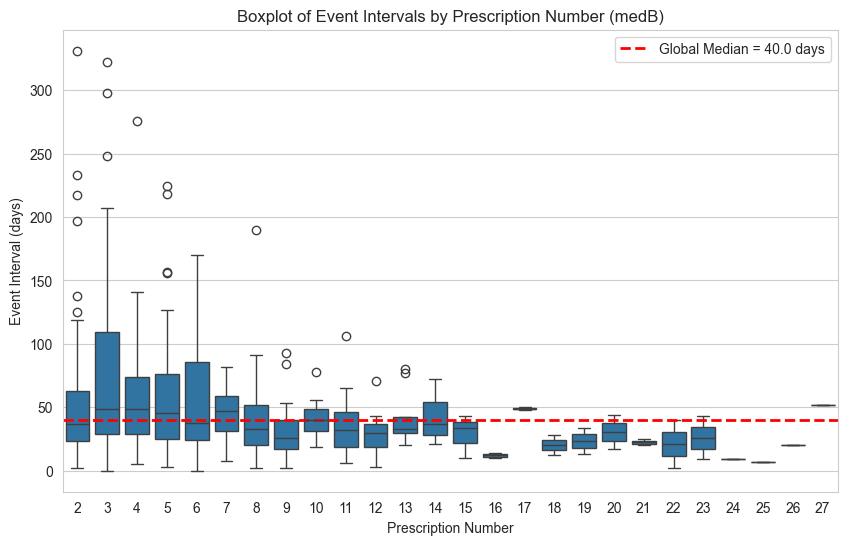

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Process Data for medB ---

# Ensure df_medB is sorted by patient and date
df_medB = df_medB.sort_values(["pnr", "eksd"])

# Create a 'p_number' column that indexes prescription events (starting at 1) per patient for medB
df_medB["p_number"] = df_medB.groupby("pnr").cumcount() + 1

# Check if 'event_interval' exists in df_medB; if not, compute it.
if "event_interval" not in df_medB.columns:
    df_medB['prev_eksd'] = df_medB.groupby("pnr")["eksd"].shift(1)
    df_medB = df_medB.dropna(subset=["prev_eksd"]).reset_index(drop=True)
    df_medB["event_interval"] = (df_medB["eksd"] - df_medB["prev_eksd"]).dt.days

# Display a preview of df_medB to verify the new columns
print("Preview of df_medB after sorting and adding p_number:")
print(df_medB.head())

# 1) Compute the global median event_interval for medB
global_median_medB = df_medB['event_interval'].median()
print("Global Median Event Interval (medB):", global_median_medB)

# 2) Create a boxplot of event intervals by prescription number (p_number) for medB
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="p_number",         # x-axis: prescription sequence number
    y="event_interval",   # y-axis: inter-prescription intervals (days)
    data=df_medB,
    showfliers=True       # Display outliers as individual points
)

# 3) Add a horizontal dashed red line at the global median event_interval for medB
plt.axhline(y=global_median_medB, color='red', linestyle='--', linewidth=2,
            label=f'Global Median = {global_median_medB:.1f} days')

# Add titles and labels for clarity
plt.title("Boxplot of Event Intervals by Prescription Number (medB)")
plt.xlabel("Prescription Number")
plt.ylabel("Event Interval (days)")
plt.legend()

# Display the plot
plt.show()


K-Means: Silhouette score for k=2: 0.5884
K-Means: Silhouette score for k=3: 0.5750
K-Means: Silhouette score for k=4: 0.5732
K-Means: Silhouette score for k=5: 0.5332
K-Means: Silhouette score for k=6: 0.5217
K-Means: Silhouette score for k=7: 0.5609
K-Means: Silhouette score for k=8: 0.5629
K-Means: Silhouette score for k=9: 0.5719

Optimal k (K-Means): 2


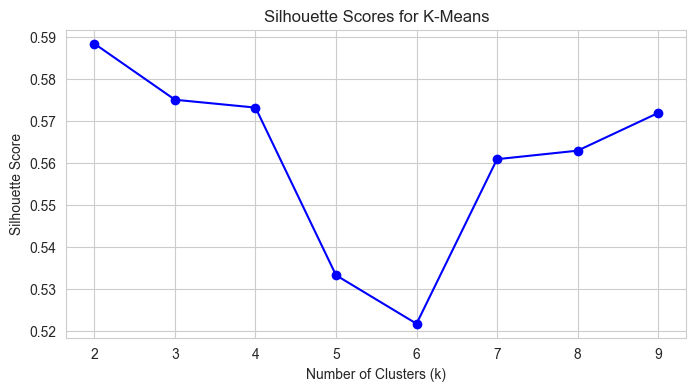

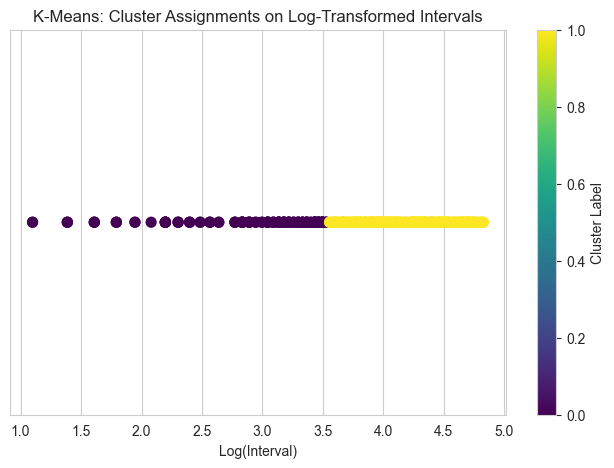

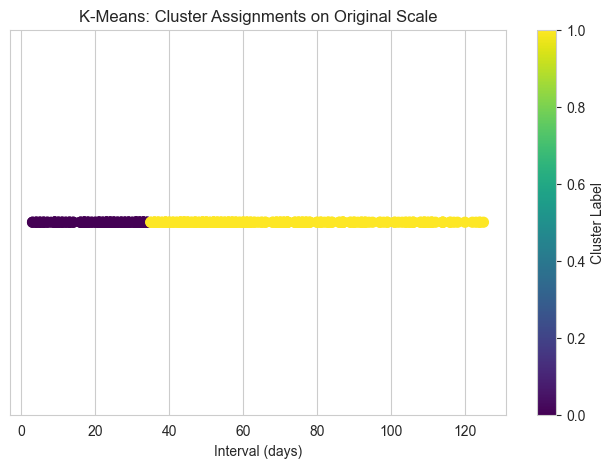

Agglomerative: Silhouette score for k=2: 0.5686
Agglomerative: Silhouette score for k=3: 0.5755
Agglomerative: Silhouette score for k=4: 0.5403
Agglomerative: Silhouette score for k=5: 0.5197
Agglomerative: Silhouette score for k=6: 0.5325
Agglomerative: Silhouette score for k=7: 0.5353
Agglomerative: Silhouette score for k=8: 0.5226
Agglomerative: Silhouette score for k=9: 0.5091

Optimal k (Agglomerative): 3


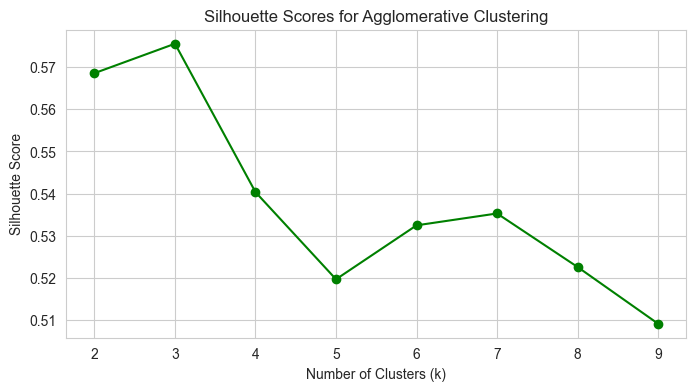

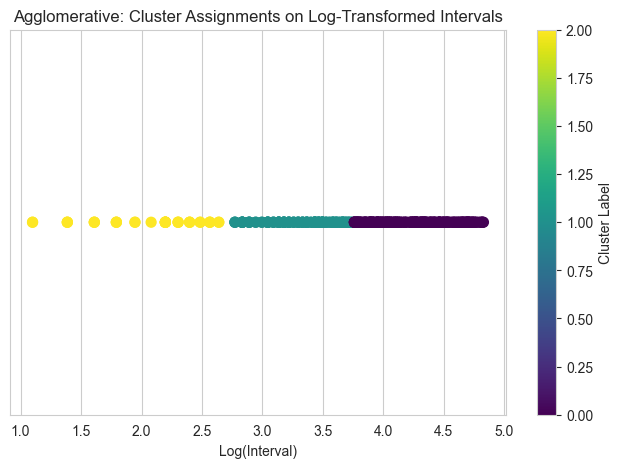

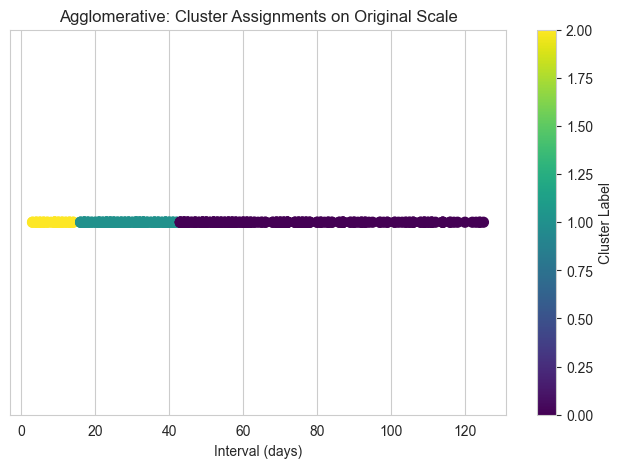

In [112]:

# --- Function for Optimal K and Silhouette Scores using K-Means ---
def optimal_k_means(log_intervals, k_range=range(2, 10)):
    sil_scores = {}
    models = {}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=1234)
        labels = km.fit_predict(log_intervals)
        score = silhouette_score(log_intervals, labels)
        sil_scores[k] = score
        models[k] = (km, labels)
        print(f"K-Means: Silhouette score for k={k}: {score:.4f}")
    
    optimal_k = max(sil_scores, key=sil_scores.get)
    print("\nOptimal k (K-Means):", optimal_k)
    
    # Visualize silhouette scores for K-Means
    plt.figure(figsize=(8, 4))
    plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o', color='blue')
    plt.title("Silhouette Scores for K-Means")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.show()
    
    return optimal_k, models[optimal_k][1], models[optimal_k][0], sil_scores

# --- Function for Optimal K and Silhouette Scores using Agglomerative Clustering ---
def optimal_agglomerative(log_intervals, k_range=range(2, 10)):
    sil_scores = {}
    models = {}
    for k in k_range:
        agglo = AgglomerativeClustering(n_clusters=k)
        labels = agglo.fit_predict(log_intervals)
        score = silhouette_score(log_intervals, labels)
        sil_scores[k] = score
        models[k] = labels
        print(f"Agglomerative: Silhouette score for k={k}: {score:.4f}")
    
    optimal_k = max(sil_scores, key=sil_scores.get)
    print("\nOptimal k (Agglomerative):", optimal_k)
    
    # Visualize silhouette scores for Agglomerative Clustering
    plt.figure(figsize=(8, 4))
    plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o', color='green')
    plt.title("Silhouette Scores for Agglomerative Clustering")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.show()
    
    return optimal_k, models[optimal_k], sil_scores

# --- Visualizations: Scatter Plot of Log-Transformed Data Colored by Cluster ---
def plot_cluster_scatter(log_intervals, labels, method_name):
    plt.figure(figsize=(8, 5))
    plt.scatter(log_intervals, [0]*len(log_intervals), c=labels, cmap='viridis', s=50)
    plt.title(f"{method_name}: Cluster Assignments on Log-Transformed Intervals")
    plt.xlabel("Log(Interval)")
    plt.yticks([])
    plt.colorbar(label="Cluster Label")
    plt.show()

# --- Main Section: Compute and Visualize for both K-Means and Agglomerative Clustering ---

# Log-transform the trimmed intervals and reshape to a 2D array
log_intervals = np.log(trimmed_intervals).reshape(-1, 1)

# --- K-Means Clustering ---
optimal_k_km, km_labels, km_model, km_sil_scores = optimal_k_means(log_intervals, k_range=range(2, 10))
plot_cluster_scatter(log_intervals, km_labels, "K-Means")

# Optional: Visualize clusters on original scale (back-transformed)
plt.figure(figsize=(8,5))
plt.scatter(np.exp(log_intervals), [0]*len(log_intervals), c=km_labels, cmap='viridis', s=50)
plt.title("K-Means: Cluster Assignments on Original Scale")
plt.xlabel("Interval (days)")
plt.yticks([])
plt.colorbar(label="Cluster Label")
plt.show()

# --- Agglomerative Clustering ---
optimal_k_agglo, agglo_labels, agglo_sil_scores = optimal_agglomerative(log_intervals, k_range=range(2, 10))
plot_cluster_scatter(log_intervals, agglo_labels, "Agglomerative")

# Optional: Visualize clusters on original scale (back-transformed)
plt.figure(figsize=(8,5))
plt.scatter(np.exp(log_intervals), [0]*len(log_intervals), c=agglo_labels, cmap='viridis', s=50)
plt.title("Agglomerative: Cluster Assignments on Original Scale")
plt.xlabel("Interval (days)")
plt.yticks([])
plt.colorbar(label="Cluster Label")
plt.show()

## **Step 9: Discussion of K-Means Limitations & Clinical Relevance**

### **K-Means Clustering Limitations:**

- **Sensitivity to Initialization & Outliers:**  
  K-Means may converge to local minima and is highly sensitive to the choice of initial centroids. Outliers can significantly distort the cluster centers, leading to suboptimal partitions.

- **Predefined Number of Clusters:**  
  The algorithm requires specifying the number of clusters (k) in advance. Although methods like silhouette analysis assist in estimating k, the final choice remains somewhat subjective.

- **Assumption of Spherical Clusters:**  
  K-Means inherently assumes that clusters are spherical and equally sized, which may not capture the complex, heterogeneous patterns of medication adherence observed in real-world data.

### **Clinical Relevance:**

- **Computed Prescription Duration:**  
  The computed median durations serve as an indirect measure of medication adherence. A significantly shorter computed duration compared to the expected prescription duration might indicate nonadherence or irregular refill patterns.

- **Identifying Patient Subpopulations:**  
  By comparing cluster distributions via visualizations (e.g., boxplots, histograms), we can potentially identify subgroups of patients with distinct medication use patterns. This differentiation may support targeted clinical interventions and personalized treatment plans.

### **Alternative Method (Agglomerative Clustering):**

- **Hierarchical Relationships:**  
  Agglomerative Clustering captures nested groupings and the hierarchical structure within the data, offering insights into the relationships between different patient groups.

- **Robustness to Outliers:**  
  This method tends to be less sensitive to outliers compared to K-Means, which may result in more robust clustering in the presence of irregular refill patterns.

- **Complementary Insights:**  
  Employing an alternative clustering method provides a complementary perspective. Differences in results between K-Means and Agglomerative Clustering can highlight potential weaknesses in one method and offer a more nuanced understanding of medication adherence patterns.


## **Step 10: Callable Function Consistency Checks**
 
 We now verify that each function produces consistent results when run independently.



🔍 Testing: preprocess_data()
Data filtered for drug code 'medA' with 449 rows after processing.
✅ Preprocess consistency check passed.

🔍 Testing: plot_and_trim_ecdf()


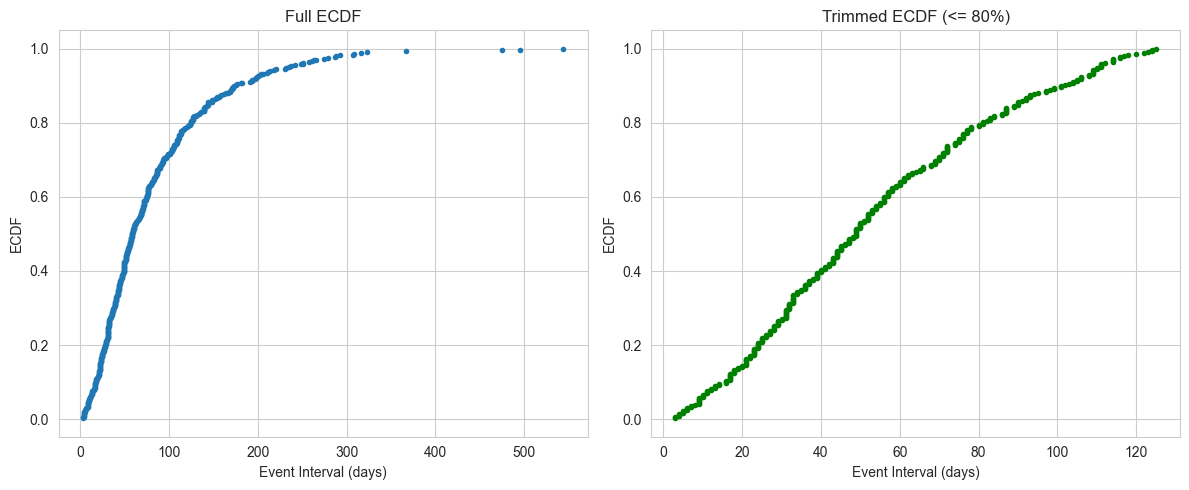

✅ ECDF trimming consistency check passed.

🔍 Testing: optimal_k_means()
Silhouette score for k=2: 0.5884
Silhouette score for k=3: 0.5750
Silhouette score for k=4: 0.5732
Silhouette score for k=5: 0.5332
Silhouette score for k=6: 0.5217
Silhouette score for k=7: 0.5609
Silhouette score for k=8: 0.5629
Silhouette score for k=9: 0.5719

Optimal k (K-Means): 2
✅ Optimal k consistency check passed. (Optimal k = 2)

🔍 Testing: kmeans_clustering()
K-Means Cluster Summary:
   cluster   min  median    max
0        0   3.0    23.0   34.0
1        1  35.0    65.0  125.0
✅ K-Means clustering consistency check passed.

🔍 Testing: agglomerative_clustering()
Agglomerative Clustering Summary:
   cluster   min  median    max
0        0   3.0    25.0   42.0
1        1  43.0    71.0  125.0
✅ Agglomerative clustering consistency check passed.

🎉 **All consistency tests passed successfully!**


In [100]:
## **Step 10: Consistency Testing for Key Functions**

# 1️⃣ **Test preprocess_data function**
print("\n🔍 Testing: preprocess_data()")
test_preprocessed = preprocess_data(df, "medA")
assert not test_preprocessed.empty, "❌ Error: Preprocessing returned an empty DataFrame!"
print("✅ Preprocess consistency check passed.")

# 2️⃣ **Test plot_and_trim_ecdf function**
print("\n🔍 Testing: plot_and_trim_ecdf()")
test_trimmed = plot_and_trim_ecdf(test_preprocessed['event_interval'].values)
assert len(test_trimmed) > 0, "❌ Error: ECDF trimming produced an empty array!"
print("✅ ECDF trimming consistency check passed.")

# 3️⃣ **Test optimal_k_means function**
print("\n🔍 Testing: optimal_k_means()")
test_log_intervals = np.log(test_trimmed).reshape(-1, 1)
test_k = optimal_k_means(test_log_intervals)
assert isinstance(test_k, int) and test_k > 0, "❌ Error: Optimal k is not a positive integer!"
print(f"✅ Optimal k consistency check passed. (Optimal k = {test_k})")

# 4️⃣ **Test K-Means clustering function**
print("\n🔍 Testing: kmeans_clustering()")
test_kmeans_summary, _ = kmeans_clustering(test_trimmed, test_k)
assert not test_kmeans_summary.empty, "❌ Error: K-Means clustering summary is empty!"
print("✅ K-Means clustering consistency check passed.")

# 5️⃣ **Test Agglomerative clustering function**
print("\n🔍 Testing: agglomerative_clustering()")
test_agglo_summary, _ = agglomerative_clustering(test_trimmed, test_k)
assert not test_agglo_summary.empty, "❌ Error: Agglomerative clustering summary is empty!"
print("✅ Agglomerative clustering consistency check passed.")

print("\n🎉 **All consistency tests passed successfully!**")


## **Conclusions and Final Insights**

### **Insights:**

- **K-Means Clustering:**  
  - Provides computed median durations that serve as estimates of prescription lengths.
  - Sensitive to initialization and outliers.
  - Requires the number of clusters (k) to be predefined, which can be somewhat subjective even with silhouette analysis.

- **Agglomerative Clustering:**  
  - Offers a robust alternative that captures hierarchical relationships within the data.
  - Tends to be less sensitive to outliers compared to K-Means.
  - Provides a different perspective on medication adherence patterns, which may reveal additional insights.

- **Visual Comparisons:**  
  - Boxplots and histograms of cluster distributions and computed durations help reveal underlying differences between the clustering methods.
  - These visual tools can assist in identifying subpopulations with distinct medication use patterns, which could be clinically relevant for targeted interventions.

### **Final Thoughts:**

- **Method Selection:**  
  The choice of clustering algorithm can significantly affect the computed prescription durations. While K-Means offers simplicity and interpretability, Agglomerative Clustering may provide more nuanced insights in the presence of irregular refill patterns.

- **Clinical Implications:**  
  The computed durations derived from these clustering approaches can serve as proxies for assessing medication adherence. Discrepancies between expected and computed durations might indicate nonadherence or other behavioral patterns, guiding further clinical investigations.

- **Next Steps:**  
  Further research could involve exploring additional clustering methods, such as DBSCAN or Gaussian Mixture Models, and integrating clinical outcomes to validate the adherence estimates.

---

*This analysis provides a comprehensive comparison of the two clustering approaches and outlines their potential clinical relevance, paving the way for further research and targeted interventions.*
